Задача: построить модель, которая по фотографии определит приблизительный возраст человека.

этапы:
- импорт библиотек и загрузка анных
- исследовательский анализ данных
- обучение и оценка нейросети

условние: MAE < 8

# Определение возраста покупателей

## Импорт библиотек и загрузка данных

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
RS = 42

In [4]:
pth = '/datasets/faces/labels.csv'

try:
    df = pd.read_csv(pth)
except FileNotFoundError:
    print('Файл не найден. Загрузка не удалась.')
except Exception as e:
    print(f'Произошла ошибка при загрузке файла: {e}')

данные выгрузилсь без ошибок

### Исследовательский анализ данных

In [6]:
df.sample()

,file_name,real_age
1999,001999.jpg,37


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


данные на месте. 7591 фотография. Для обучения нейросети не так много, но хватит.

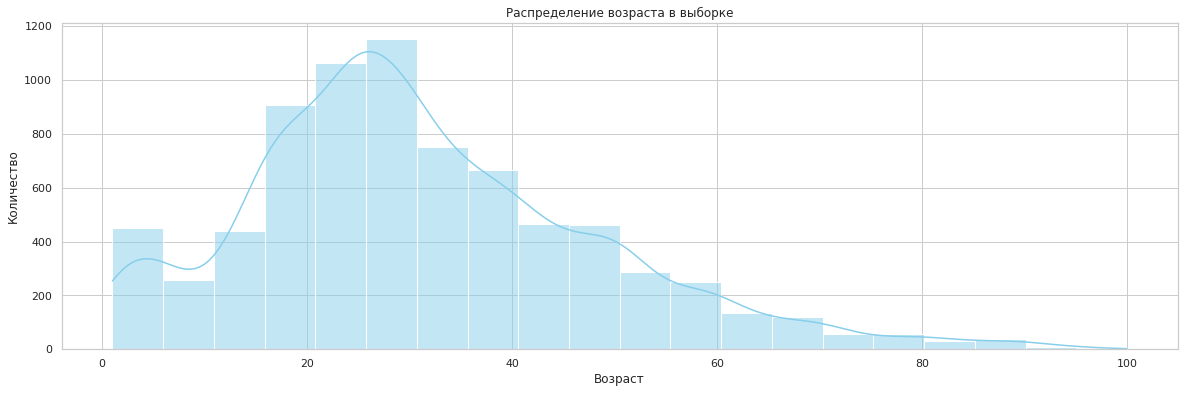

In [4]:
plt.figure(figsize=(20, 6))
sns.set(style='whitegrid')
sns.histplot(df['real_age'], bins=20, kde=True, color='skyblue')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Распределение скорее лог.нормальное. Наименьший возраст на фотографиях до 1 года, наибольшее колличество фото людей в возрасте 25-30 лет >1000, есть небольшое колличество фотографий на котрых людям боле 70 лет ~ 300.

In [5]:
image_directory = '/datasets/faces/final_files'

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='file_name',
    y_col='real_age',
    labels='inferred',
    label_mode='int',
    target_size=(150, 150),
    batch_size=16, 
    class_mode='raw',
    shuffle=True,
    random_state=RS
)

Found 7591 validated image filenames.


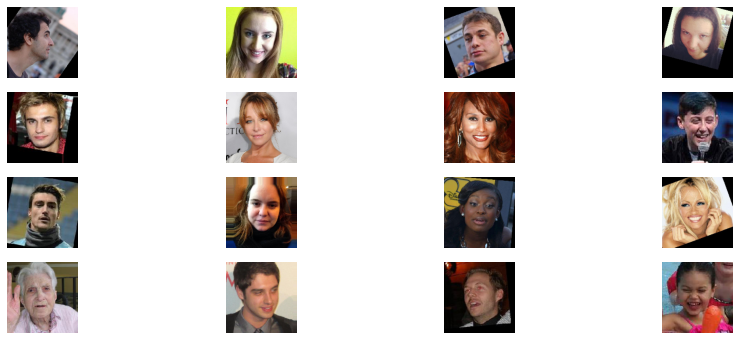

In [7]:
plt.figure(figsize=(15, 6))
for i in range(16):  
    batch = generator.next()
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch[0][i])
    plt.axis('off')
plt.show()

Выборка содержит 7591 фото. Распределение возраста в выборке показывает что у нас есть множетво возрастных групп (от 0+ до 90+) ,визуальный анализ фотографий показывает разнообразие лиц и параметров фото. Все это важно для качественного обучения модели на разнообразных данных, но наколько я понимаю черно-белые фото нужно привести в цветной формат ( добавить каналы ). 

## Обучение модели

``` python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

import numpy as np

import pandas as pd


def load_train(path):

    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1. / 255)

    train_data = datagen.flow_from_dataframe(
         directory=path + 'final_files/',
         dataframe=pd.read_csv(path + 'labels.csv'),
         x_col='file_name',
         y_col='real_age',
         labels='inferred',
         label_mode='int',
         target_size=(150, 150),
         batch_size=16, 
         class_mode='raw',
         shuffle=True,
         subset='training',
         seed=42)

    return train_data 

def load_test(path):

    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1. / 255)
                                 
    test_data = datagen.flow_from_dataframe(
         directory=path + 'final_files/',
         dataframe=pd.read_csv(path + 'labels.csv'),
         x_col='file_name',
         y_col='real_age',
         labels='inferred',
         label_mode='int',
         target_size=(150, 150),
         batch_size=16, 
         class_mode='raw',
         shuffle=True,
         subset='validation',
         seed=42)

    return test_data

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.00001), metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,

                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

## Анализ обученной модели

Модель с задачей справляется удовлетворительно. Получен результат < 7 по описанию проекта считается "отличным". За время обучение видно что сразу были выбраны не самые удачные веса, после присутствуют не критичные скачки в сторону увеличения МАЕ на валидационой выборке в 7,9,10,13,16,17,20 эпохах. При этом на тренировочной выборке MAE снижется более уверенно и плавно. Видимо сеть переобучается. Думаю что результат можно сделать еще лучше:
- попробовать привести все изображения к цветным на этапе загрузки с помощью OpenCV

if image.shape[2] == 1:

        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

- использовать  аугментацию: вращение, отражение и изменение яркости, чтобы увеличить разнообразие обучающих данных( в выборке как я понял уже присуствует некоторая аугментация, сдвиги, блюры то что увидел) 

- сделать подбор параметров батча, lr, эпохи, функция потерь, оптимизатор

- попробовать адаптивный dropout

- критерий останова 

Но ограничения на вход "именно так как в образце" для учебных проектов не позволяют этого сделать